# Augmented Reality with Python 3 and OpenCV 4.2

This is a basic code of an augmented reality system. 

> *TODO: include introduction about augmented reality and the notebook.*

The basic structure is:

1. **Prepare data**
2. **Read data**
3. **Recognize**
4. **Homography**
5. **Pose Estimation**
5. **Display**

## 1. Prepare data

Include libraries in Python, such as OpenCV, numpy, and matplotlib.

> *TODO: brief introduction about python, opencv, numpy and matplotlib.*

In [1]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

## 2. Read data

### Read reference image

Load the reference image and convert to gray scale.

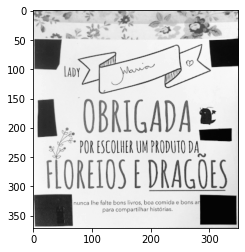

In [2]:
# Load reference image and convert it to gray scale
referenceImage = cv2.imread('../img/referenceImage.jpg', 0)

# Show image
plt.imshow(referenceImage, cmap='gray')
plt.show()

### Read source image

Load the source image and convert to gray scale

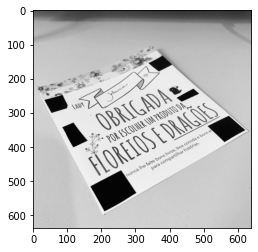

In [3]:
# Load the source image and convert it to gray scale
sourceImage = cv2.imread('../img/sourceImage_04.jpg', 0) 

# Show image
plt.imshow(sourceImage, cmap='gray')
plt.show()

## 3. Recognize

> *brief description*

Feature based recognition method. This kind of methods, consist in three main steps: 
* **3.1 feature detection or extraction,** 
* **3.2 feature description** and 
* **3.3 feature matching**.

### 3.1 Feature extraction

> *brief description*

### 3.2 Feature description

> *brief description*

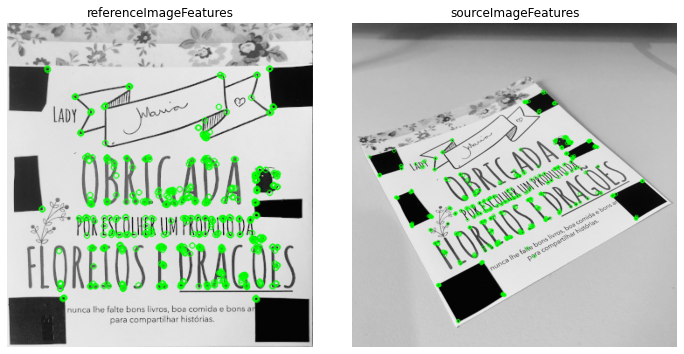

In [4]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
referenceImagePts = orb.detect(referenceImage, None)
sourceImagePts = orb.detect(sourceImage, None)


# compute the descriptors with ORB
referenceImagePts, referenceImageDsc = orb.compute(referenceImage, referenceImagePts)
sourceImagePts, sourceImageDsc = orb.compute(sourceImage, sourceImagePts)

#  Paint the key points over the original image
referenceImageFeatures = cv2.drawKeypoints(referenceImage, referenceImagePts,
                                           referenceImage, color=(0,255,0), flags=0)
sourceImageFeatures = cv2.drawKeypoints(sourceImage, sourceImagePts,
                                           sourceImage, color=(0,255,0), flags=0)


# Show image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(referenceImageFeatures, cmap='gray')
plt.title('referenceImageFeatures')
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(sourceImageFeatures, cmap='gray')
plt.title('sourceImageFeatures')
plt.tight_layout()
plt.show()

### 3.3 Feature matching

> *brief description*

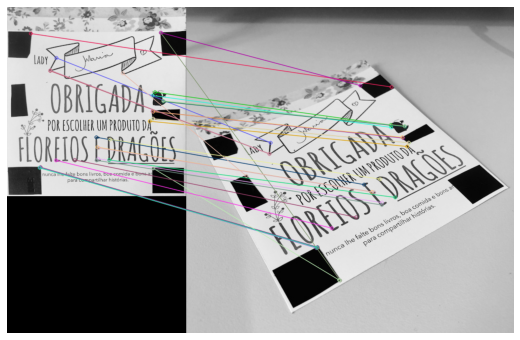

In [5]:
MIN_MATCHES = 30
            
# create brute force  matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Compute model keypoints and its descriptors
referenceImagePts, referenceImageDsc = orb.detectAndCompute(referenceImage, None)

# Compute scene keypoints and its descriptors
sourceImagePts, sourceImageDsc = orb.detectAndCompute(sourceImage, None)

# Match frame descriptors with model descriptors
matches = bf.match(referenceImageDsc, sourceImageDsc)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

if len(matches) > MIN_MATCHES:
    # draw first 15 matches.
    idxPairs = cv2.drawMatches(referenceImage, referenceImagePts, sourceImage, sourceImagePts,
                          matches[:MIN_MATCHES], 0, flags=2)
    # show result
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(idxPairs, cmap='gray')
    plt.show()
else:
    print("Not enough matches have been found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

## 4. Homography

#### Find transformation or Homography estimation

+ Find the perpective transformation of that object
+ Get geometric transformation between reference image and source image
+ It needs at least four correct points to find the transformation.

This information is sufficient to find the object exactly. We can use a function **cv2.findHomography()**. If we pass the set of points from both the images, it will find the perpective transformation of that object. Then we can use **cv2.perspectiveTransform()** to find the object. It needs atleast four correct points to find the transformation.

We have seen that there can be some possible errors while matching which may affect the result. To solve this problem, algorithm uses **RANSAC** or LEAST_MEDIAN. So good matches which provide correct estimation are called **inliers** and remaining are called **outliers**. 

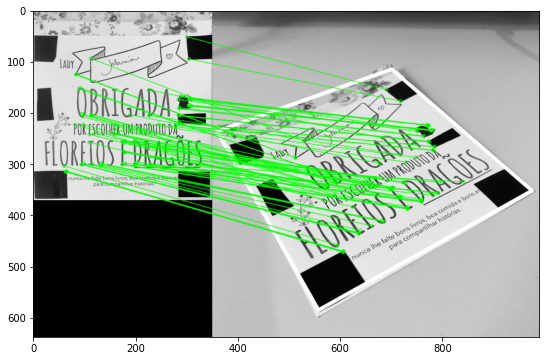

In [6]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, mask = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    sourceImageMarker = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True,
                                      255, 5, cv2.LINE_AA)
    
else:
    print("Not enough matches are found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

# Draw the matches
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None,
                      matchesMask=matchesMask, flags=2)
result = cv2.drawMatches(referenceImage, referenceImagePts, sourceImageMarker,
                         sourceImagePts, matches, None, **drawParameters)

# Show image
plt.figure(figsize=(12, 6))
plt.imshow(result, cmap='gray')
plt.show()

## 5. Pose Estimation

In [7]:
# obtain 3D projection matrix from homography matrix and camera parameters
camera_parameters = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]])

def projection_matrix(camera_parameters, homography):
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    return np.dot(camera_parameters, projection)

In [8]:
# project cube or model
def render(img, obj, projection, model, color=False):

    vertices = obj.vertices
    scale_matrix = np.eye(3) * 6
    h, w = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
    #     # render model in the middle of the reference surface. To do so,
    #     # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)

        cv2.fillConvexPoly(img, imgpts, (80, 27, 211))
#         cv2.fillConvexPoly(img, imgpts, (255, 0, 0))
    return img

In [9]:
from objloader_simple import *

# Load 3D model from OBJ file
obj = OBJ('../models/chair.obj', swapyz=True)  

# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, _ = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
#     matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    frame = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True, 255, 3, cv2.LINE_AA)
    
    # obtain 3D projection matrix from homography matrix and camera parameters
    projection = projection_matrix(camera_parameters, homography)  
    # project cube or model
    frame = render(frame, obj, projection, referenceImage, False)

## 6. Display

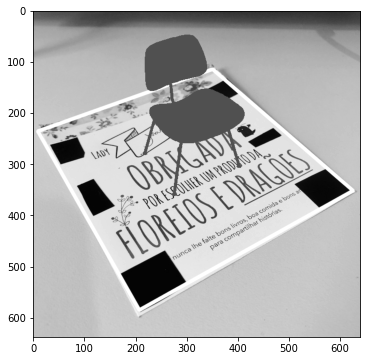

In [10]:
# Show image
plt.figure(figsize=(12, 6))
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.imshow(frame, cmap='gray')
plt.show()

## References

https://github.com/juangallostra/augmented-reality

http://www.pygame.org/wiki/OBJFileLoader

https://github.com/yarolig/OBJFileLoader

https://bitesofcode.wordpress.com/2017/09/12/augmented-reality-with-python-and-opencv-part-1/

https://bitesofcode.wordpress.com/2018/09/16/augmented-reality-with-python-and-opencv-part-2/
